In [1]:
import numpy as np
import pandas as pd
from scipy.stats import randint
import matplotlib.pyplot as plt
% matplotlib inline

x=pd.read_csv('processed_scaled.csv',index_col=0)
x.drop('Graduation_Rate_School', axis=1,inplace=True)
y=pd.read_csv('grad_rate.csv', header=None)[1].values

In [2]:
x.shape

(121, 192)

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(criterion='mse', n_jobs=-1, random_state=5)

rf_params = {'n_estimators': randint(5,100), 
             'max_features':randint(10, 50),
             'max_depth': randint(5, 10), 
             'min_samples_split': randint(5, 20)}

rand_search = RandomizedSearchCV(estimator=rf, param_distributions=rf_params, cv=5, n_jobs=-1, n_iter=50)
rand_search.fit(x, y)
print rand_search.best_score_
print rand_search.best_params_

0.700970137513637
{'max_features': 40, 'min_samples_split': 14, 'n_estimators': 43, 'max_depth': 8}


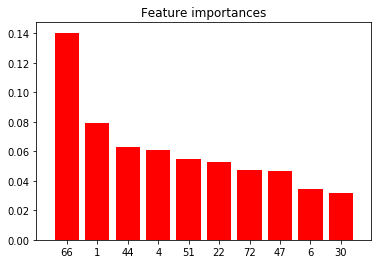

In [5]:
# building model with best params
rf = RandomForestRegressor(n_estimators=34, max_features=36, min_samples_split=5, max_depth=8, n_jobs=-1, random_state=5)
rf.fit(x,y)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_ten = indices[:10]

plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[top_ten],
       color="r", align="center")
plt.xticks(range(10), top_ten)
plt.xlim([-1, 10])
plt.show()

In [6]:
# get names of important features
for i in top_ten:
    print x.columns[i]

Student_Growth_Rating_NO DATA AVAILABLE
Average_ACT_School
Bilingual_Services_U
Attainment_ACT_Grade_11_Pct
Overall_Rating_Inability to Rate
Student_Special_Ed_Pct
Student_Attainment_Rating_NO DATA AVAILABLE
Refugee_Services_U
College_Persistence_School_Pct_Year_2
School_Type_Citywide-Option


### Regression Models Without Feature Selection

All models run using grid search with 5-fold cross validation on RMSE

In [26]:
from sklearn.linear_model import Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.model_selection import GridSearchCV

#### Lasso

In [27]:
lasso = Lasso(max_iter=50000)
l_space = {'alpha': np.logspace(-4,1,20)}
grid = GridSearchCV(estimator=lasso, param_grid = l_space, scoring='neg_mean_squared_error',n_jobs=-1, cv=5)
grid.fit(x, y)

print 'Best RMSE: '+str(np.sqrt(grid.best_score_*-1))
print grid.best_params_

Best RMSE: 8.93679543620526
{'alpha': 0.1438449888287663}


#### Ridge

In [5]:
ridge = Ridge(max_iter=100000)
r_space = {'alpha': np.logspace(-1,1,20)}
grid = GridSearchCV(estimator=ridge, param_grid = r_space, scoring='neg_mean_squared_error',n_jobs=-1, cv=5)
grid.fit(x, y)

print 'Best RMSE: '+str(np.sqrt(grid.best_score_*-1))
print grid.best_params_

Best RMSE: 10.192947565943104
{'alpha': 2.3357214690901213}


#### Elastic Net

In [6]:
EN = ElasticNet(max_iter=100000)
en_space = {'alpha': np.logspace(-2,1,20), 'l1_ratio':np.linspace(0.01,1,10)}
grid = GridSearchCV(estimator=EN, param_grid = en_space, scoring='neg_mean_squared_error',n_jobs=-1, cv=5)
grid.fit(x, y)

print 'Best RMSE: '+str(np.sqrt(grid.best_score_*-1))
print grid.best_params_

Best RMSE: 8.960413689993084
{'alpha': 0.12742749857031335, 'l1_ratio': 1.0}


#### SGD

In [7]:
#sgd = SGDRegressor(max_iter=100000)
#sgd_space = {'alpha': np.linspace(0.0001,1,10), 'penalty':['l2', 'l1'], 'l1_ratio':np.linspace(0.01,1,10)}
#grid = GridSearchCV(estimator=sgd, param_grid = sgd_space, scoring='neg_mean_squared_error',n_jobs=-1, cv=5)
#grid.fit(x, y)

#print 'Best RMSE: '+str(np.sqrt(grid.best_score_*-1))
#print grid.best_params_

### With Feature Selection

In [7]:
from sklearn import metrics
from sklearn import feature_selection
from sklearn.model_selection import cross_val_score

In [12]:
def get_opt_features(model, x, y):
    percentiles = range(1, 100, 10)
    results = []
    for i in range(1, 100, 10):
        fs = feature_selection.SelectPercentile(feature_selection.f_regression, percentile=i)
        x_fs = fs.fit_transform(x, y)
        scores = cross_val_score(model, x_fs, y, cv=5)
        results = np.append(results, scores.mean())

    optimal_percentile = percentiles[np.where(results == results.max())[0][0]]

    opt_fs = feature_selection.SelectPercentile(feature_selection.f_regression, percentile=optimal_percentile)
    return x_fs, optimal_percentile

#### Lasso

In [10]:
fs_lasso = Lasso(max_iter=50000)
x_best, p = get_opt_features(fs_lasso, x, y)

grid = GridSearchCV(estimator=fs_lasso, param_grid = l_space, scoring='neg_mean_squared_error',n_jobs=-1, cv=5)
grid.fit(x_best, y)

print 'Feature Percentage: '+str(p)
print 'Best RMSE: '+str(np.sqrt(grid.best_score_*-1))
print grid.best_params_

Feature Percentage: 31
Best RMSE: 8.90633721822287
{'alpha': 0.14384498882876628}


#### Ridge

In [12]:
fs_ridge = Ridge()

grid = GridSearchCV(estimator=fs_ridge, param_grid = r_space, scoring='neg_mean_squared_error', cv=5)
grid.fit(x_best, y)

print 'Feature Percentage: '+str(p)
print 'Best RMSE: '+str(np.sqrt(grid.best_score_*-1))
print grid.best_params_

Feature Percentage: 31
Best RMSE: 10.165434282194582
{'alpha': 2.3357214690901213}


#### Elastic Net

In [11]:
fs_en = ElasticNet(max_iter=100000)

grid = GridSearchCV(estimator=fs_en, param_grid = en_space, scoring='neg_mean_squared_error',n_jobs=-1, cv=5)
grid.fit(x_best, y)

print 'Feature Percentage: '+str(p)
print 'Best RMSE: '+str(np.sqrt(grid.best_score_*-1))
print grid.best_params_

Feature Percentage: 31
Best RMSE: 8.91902145551519
{'alpha': 0.12742749857031335, 'l1_ratio': 1.0}


#### SGD (not using for now)

In [ ]:
fs_sgd = SGDRegressor(max_iter=100000)
x_sgd, p = get_opt_features(fs_sgd, x, y)

grid = GridSearchCV(estimator=sgd, param_grid = sgd_space, scoring='neg_mean_squared_error',n_jobs=-1, cv=5)
grid.fit(x, y)

print 'Best RMSE: '+str(np.sqrt(grid.best_score_*-1))
print grid.best_params_

Code to show variables selected by the best model.

In [19]:
fs = feature_selection.SelectPercentile(feature_selection.f_regression, percentile=31)
opt_fs=fs.fit_transform(x,y)

In [20]:
model=Lasso(alpha=0.14384498882876628)
mdl=model.fit(opt_fs,y)

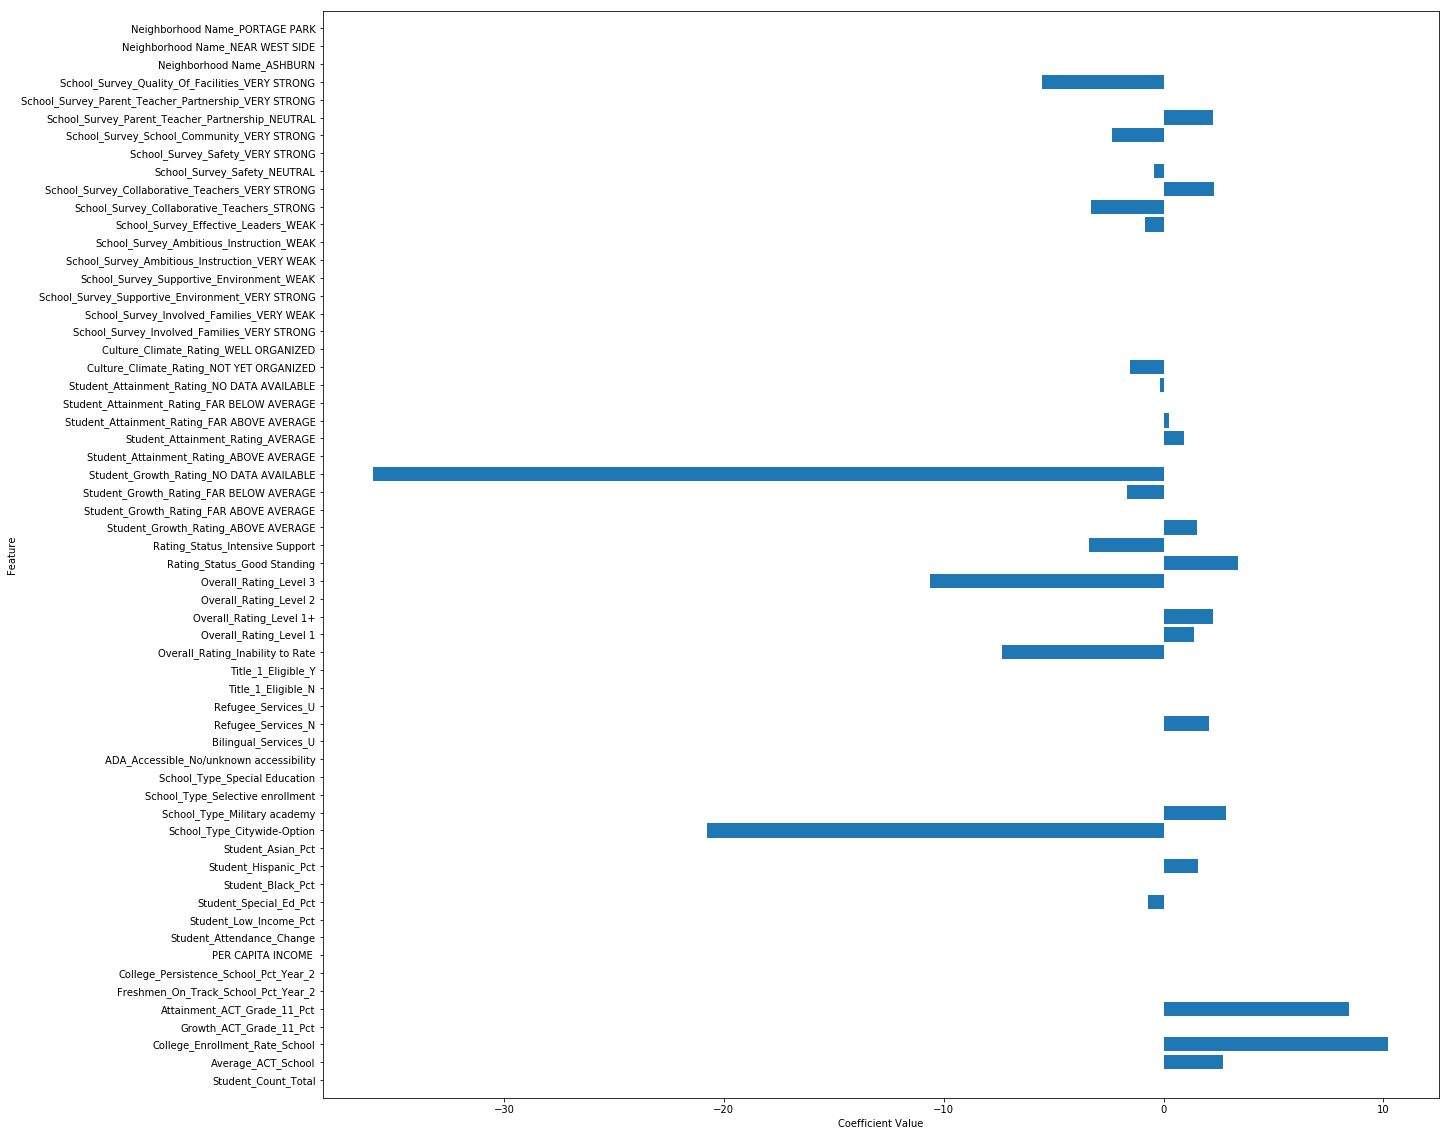

In [23]:
names = x.columns.values
import pylab as pl
%matplotlib inline
fig_size = pl.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 20

def plot_coefficients(model, n_features, feature_names):
    pl.barh(range(n_features), model.coef_, align='center')
    pl.yticks(np.arange(n_features), feature_names)
    pl.xlabel("Coefficient Value")
    pl.ylabel("Feature")
    pl.ylim(-1, n_features)
    pl.rcParams["figure.figsize"] = fig_size
    
plot_coefficients(mdl, len(names[fs.get_support(indices=True)]), names[fs.get_support(indices=True)])

In [30]:
fs_lasso = Lasso(max_iter=50000)
x_best, p = get_opt_features(fs_lasso, x, y)

grid = GridSearchCV(estimator=fs_lasso, param_grid = l_space, scoring='r2',n_jobs=-1, cv=5)
grid.fit(x_best, y)

print 'Feature Percentage: '+str(p)
print 'Best r2: '+str(grid.best_score_)
print grid.best_params_

Feature Percentage: 31
Best r2: 0.760051097094795
{'alpha': 0.1438449888287663}


In [33]:
len(opt_fs[0,:])

60